# AI in Industry Project  
## Predicting Road Accident Risk (Kaggle Playground Series S5E10)

**Student:** *[Lukas Wijk & Brage Vik]*  
**Course:** AI in Industry  
**Goal:** Use machine learning to predict the likelihood of road accidents using the provided dataset.




In [1]:
# Setup

import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import util


figsize=(16, 5)

/Users/lukaswijk/Library/Caches/pypoetry/virtualenvs/ai-industry-project-ngXwwyBX-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# A look at the data

The dataset contains road accident data with various features and a target variable indicating accident risk.

In [2]:
# Import and load data
train = util.load_data("../data/train.csv")
test = util.load_data("../data/test.csv")

print("Training data shape:", train.shape)
print("Test data shape:", test.shape)
print("\nTraining data info:")
print(train.describe(include="all"))
print(f"missing training values: {train.isnull().sum().sum()}")
print(f"missing test values: {test.isnull().sum().sum()}")

Training data shape: (517754, 14)
Test data shape: (172585, 13)

Training data info:
                   id road_type      num_lanes      curvature    speed_limit  \
count   517754.000000    517754  517754.000000  517754.000000  517754.000000   
unique            NaN         3            NaN            NaN            NaN   
top               NaN   highway            NaN            NaN            NaN   
freq              NaN    173672            NaN            NaN            NaN   
mean    258876.500000       NaN       2.491511       0.488719      46.112575   
std     149462.849975       NaN       1.120434       0.272563      15.788521   
min          0.000000       NaN       1.000000       0.000000      25.000000   
25%     129438.250000       NaN       1.000000       0.260000      35.000000   
50%     258876.500000       NaN       2.000000       0.510000      45.000000   
75%     388314.750000       NaN       3.000000       0.710000      60.000000   
max     517753.000000       NaN    

The fourteen columns consits of a unique id for each road, 12 input(?) features and the target feature accident_risk. 
The accident_risk column is not present in the test set.

The data is synthetic, so we don't have to deal with missing values.

Some of the columns consists of non-numeric data types, such as road_type which can take on the values "highway", "rural" or "urban".
We transform these columns, by mapping each possible value to a unique integer.
This mapping most likley introduces non-linearity to the data, which we will have to account for.

TODO: should we normalize data in some way? Prof reapeats that a lot.

In [3]:
util.cast_columns_to_categories(train)
util.cast_columns_to_categories(test)

In [4]:
# Separate features and target from training data
X_train = train.drop(columns=['id', 'accident_risk'])
y_train = train['accident_risk']

# Prepare test features (without accident_risk since it's missing)
X_test = test.drop(columns=['id'])

# Split training data for validation (80-20 split)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("\nTraining set shape:", X_train_split.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (414203, 12)
Validation set shape: (103551, 12)


### Correlation to Target Variable

TODO: explain method

In [5]:
# TODO: plots of correlations as shown is lecture 6.1

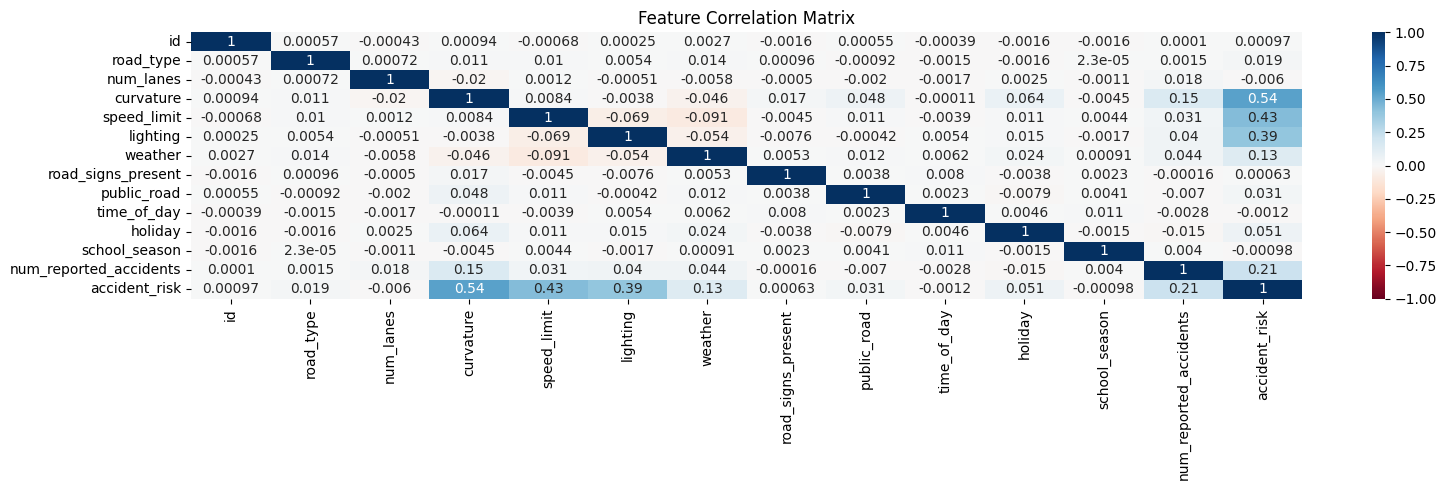

In [6]:
plt.figure(figsize=figsize)
seaborn.heatmap(train.corr(method="pearson"), annot=True, vmin=-1, vmax=1, cmap="RdBu")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

Unsurprisingly, we find that curvature, speed_limit, lightning, weather and num_reported_accidents shows the strongest correlation with the accident risk.

# Accident risk preditction

Our initial goal is to predict the accident risk for each road the data set, which we'll do using a number of machine learning models. 
We'll use regression techniques since accident_risk is a continuous value between 0 and 1.

## Model Training

We'll train multiple regression models and compare their performance:
- **Linear Regression**: Baseline model, provides interpretability
- **Random Forest**: Captures non-linear relationships, robust to outliers
- **Gradient Boosting**: Often performs best on structured data
- **Neural Network (MLPRegressor)**: Deep learning approach for comparison

In [7]:

# Dictionary to store models and their performance
models = {}
results = []


### Linear Regression

**Linear Regression** is our first and simplest regression model. It attempts to find the best-fitting straight line through the data points.
Linear regression models the relationship between features and the target using a linear equation:

**y = m₁·x₁ + m₂·x₂ + ... + mₙ·xₙ + b**

Where:
- **y** = predicted accident risk (output)
- **x₁, x₂, ..., xₙ** = input features (speed limit, curvature, weather, etc.)
- **m₁, m₂, ..., mₙ** = coefficients (weights showing how much each feature affects the prediction)
- **b** = intercept (baseline prediction when all features are zero)

#### Why We decided to use Linear Regression

1. **Baseline Model**: Serves as a simple benchmark to compare against more complex models like Random Forest and Gradient Boosting.

2. **Interpretability**: Easy to understand why predictions are made. Each coefficient directly shows the impact of each feature:
   - Positive coefficient = feature increases accident risk
   - Negative coefficient = feature decreases accident risk
   - Larger magnitude = stronger effect

3. **Computational Efficiency**: 
   - Trains very quickly, even on large datasets
   - Low memory requirements
   - Good for rapid prototyping

4. **Transparency**: Unlike "black box" models like "random forest", you can see exactly which features matter most.

#### Limitations

Linear regression assumes:
- **Linear relationships**: The relationship between features and target follows a straight line
- **No complex interactions**: Features don't interact in non-linear ways

Given that our data includes categorical features (road_type, weather, etc.) that were encoded as integers, there are likely **non-linear patterns** in your data. This is why we later test multiple models to find the best performer!

#### In The Project

```python
lr_model = LinearRegression()
lr_model.fit(X_train_split, y_train_split)  # Learn the coefficients
y_val_pred_lr = lr_model.predict(X_val)     # Make predictions
```

The model learns the optimal coefficients from the training data, then uses them to predict accident risk on the validation set. Performance is measured using MSE, MAE, and R² metrics.

In [8]:

# start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train_split, y_train_split)
# lr_train_time = time.time() - start_time


y_val_pred_lr = lr_model.predict(X_val)
lr_mse = mean_squared_error(y_val, y_val_pred_lr)
lr_mae = mean_absolute_error(y_val, y_val_pred_lr)
lr_r2 = r2_score(y_val, y_val_pred_lr)

models['Linear Regression'] = lr_model
results.append({
    'Model': 'Linear Regression',
    'MSE': lr_mse,
    'MAE': lr_mae,
    'R²': lr_r2,
    # 'Time': lr_train_time
})
print(f"MSE: {lr_mse:.6f}, MAE: {lr_mae:.6f}, R²: {lr_r2:.4f}")

MSE: 0.007822, MAE: 0.070809, R²: 0.7167


### Random forest regressor

A desicion tree regressor is a tree like structure used to preditc the target value.
It works by asking a series of questions about the features of a data point.
Once this process reaches a leaf node, it outputs a predictive value based on the average of the training data points that also reach this node.

Well be using a more sophisticated method, namley a random forest.
Unlike a simple desicion tree, a random forest uses an army of desicion trees, each trained on a subset of the data and using a subset of the features to predict the result.
The prediction result is calculated by averaging the individual prediction of each tree. 
This goal of this modification is to reduce the overfitting present in regular desicion trees.

In [9]:

# start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
rf_model.fit(X_train_split, y_train_split)
# rf_train_time = time.time() - start_time

y_val_pred_rf = rf_model.predict(X_val)
rf_mse = mean_squared_error(y_val, y_val_pred_rf)
rf_mae = mean_absolute_error(y_val, y_val_pred_rf)
rf_r2 = r2_score(y_val, y_val_pred_rf)

models['Random Forest'] = rf_model
results.append({
    'Model': 'Random Forest',
    'MSE': rf_mse,
    'MAE': rf_mae,
    'R²': rf_r2,
    # 'Time': rf_train_time
})
print(f"MSE: {rf_mse:.6f}, MAE: {rf_mae:.6f}, R²: {rf_r2:.4f}")


MSE: 0.003237, MAE: 0.044075, R²: 0.8828


### Gradient Boosting Regressor

Gradient Boosting is an advanced ensemble learning technique that builds multiple weak decision trees sequentially, where each new tree corrects the mistakes made by previous trees.

Gradient Boosting operates through an iterative process:

1. **Start Simple**: Begin with a simple initial prediction (often the mean of the target)
2. **Calculate Errors**: Compute the residuals (errors) from the current prediction
3. **Add Trees**: Train a new decision tree to predict these residuals
4. **Update Predictions**: Add the new tree's predictions (scaled by a learning rate) to the ensemble
5. **Repeat**: Continue this process, each new tree focusing on correcting previous mistakes

**Key Formula:**
```
F(x) = F₀(x) + η·T₁(x) + η·T₂(x) + ... + η·Tₙ(x)
```

Where:
- **F(x)** = final prediction
- **F₀(x)** = initial prediction
- **η** = learning rate (controls step size)
- **Tᵢ(x)** = i-th decision tree

#### Why We Use Gradient Boosting

1. **Great Performance**: Often achieves good results on structured/tabular data compared to single models

2. **Handles Non-Linear Relationships**: Automatically captures complex patterns and feature interactions without manual feature engineering

3. **Robust to Outliers**: The sequential correction process makes it less sensitive to individual outliers

4. **Feature Importance**: Provides meaningful feature importance scores showing which features matter most

5. **Flexible**: Can optimize for different loss functions (regression, classification, ranking)

#### Differences from Random Forest

| Aspect | Random Forest | Gradient Boosting |
|--------|---------------|-------------------|
| **Tree Building** | Parallel (independent trees) | Sequential (each learns from previous) |
| **Learning** | Each tree learns independently | Each tree corrects prior mistakes |
| **Speed** | Faster training | Slower (sequential process) |
| **Accuracy** | Good | Often better on structured data |
| **Overfitting Risk** | Lower | Higher (requires careful tuning) |

#### Hyperparameters in Our Project

```python
GradientBoostingRegressor(
    n_estimators=200,      # Number of boosting stages (trees)
    learning_rate=0.05,    # Shrinks contribution of each tree (lower = more conservative)
    max_depth=5,           # Maximum depth of each tree (prevents overfitting)
    random_state=42        # Reproducibility
)
```

- **n_estimators**: More trees = potentially better, but slower and risk of overfitting
- **learning_rate**: Smaller = slower learning but often better generalization
- **max_depth**: Smaller = simpler trees, reduces overfitting

#### In Our Project

```python
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5)
gb_model.fit(X_train_split, y_train_split)  # Build 200 sequential trees
y_val_pred_gb = gb_model.predict(X_val)     # Make predictions
```

The model trains 200 decision trees sequentially, each learning from the residuals of the previous ones. This typically results in strong predictive performance in our accident risk prediction task.

In [89]:
# start_time = time.time()
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, 
                                      max_depth=5, random_state=42)
gb_model.fit(X_train_split, y_train_split)
# gb_train_time = time.time() - start_time

y_val_pred_gb = gb_model.predict(X_val)
gb_mse = mean_squared_error(y_val, y_val_pred_gb)
gb_mae = mean_absolute_error(y_val, y_val_pred_gb)
gb_r2 = r2_score(y_val, y_val_pred_gb)

models['Gradient Boosting'] = gb_model
results.append({
    'Model': 'Gradient Boosting',
    'MSE': gb_mse,
    'MAE': gb_mae,
    'R²': gb_r2,
    # 'Time': gb_train_time
})
print(f"MSE: {gb_mse:.6f}, MAE: {gb_mae:.6f}, R²: {gb_r2:.4f}")


MSE: 0.003184, MAE: 0.043832, R²: 0.8847


### Neural Networks Regressor

Our last model is a multi-layer perceptron regressor, which is a type of neural network.
Neural networks are very general in their capabilities, and should be able to handle the non-linearity of our data.

The model consits of a number of layers of interconnected nodes or neurons, which are divided into the input layer, the hidden layers, and the output layer.
A neuron on a hidden layer will takes as input a weighted sum of the outputs of the previous layer, and gives as output this sum passed through the activation function.
The neurons on the input layer takes the features as input instead, while the single output layer neuron is the predicted feature.
During training, the model calculates the RMS error of it's predictions and uses it to update the it's parameters using a gradient decent method.

While picking hyper-parameters for the model, it's important to strike a balance between an underfitting and overfitting model.
Our task is a fairly simple regression task, so we start with simple hyper-parameters before adjusting them. 
In our relativly small dataset, we don't worry too much about training time.

In [11]:
mlp_model = MLPRegressor(
    # model behaivor
    hidden_layer_sizes=(32, 16, 8),
    activation="tanh",
    # training behavior
    solver="adam",
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
)
mlp_model.fit(X_train_split, y_train_split)

y_val_pred_mlp = mlp_model.predict(X_val)
mlp_mse = mean_squared_error(y_val, y_val_pred_mlp)
mlp_mae = mean_absolute_error(y_val, y_val_pred_mlp)
mlp_r2 = r2_score(y_val, y_val_pred_mlp)

models["Neural Network"] = mlp_model
results.append(
    {
        "Model": "Neural Network",
        "MSE": mlp_mse,
        "MAE": mlp_mae,
        "R²": mlp_r2,
        # 'Time': mlp_train_time
    }
)
print(f"MSE: {mlp_mse:.6f}, MAE: {mlp_mae:.6f}, R²: {mlp_r2:.4f}")


MSE: 0.003307, MAE: 0.044660, R²: 0.8802


## Model Evaluation and Comparison


MODEL PERFORMANCE COMPARISON (on Validation Set)
            Model      MSE      MAE       R²
Linear Regression 0.007822 0.070809 0.716707
    Random Forest 0.003237 0.044075 0.882774
Gradient Boosting 0.003167 0.043678 0.885291
   Neural Network 0.003307 0.044660 0.880225

✓ Best model: Gradient Boosting with R² = 0.8853


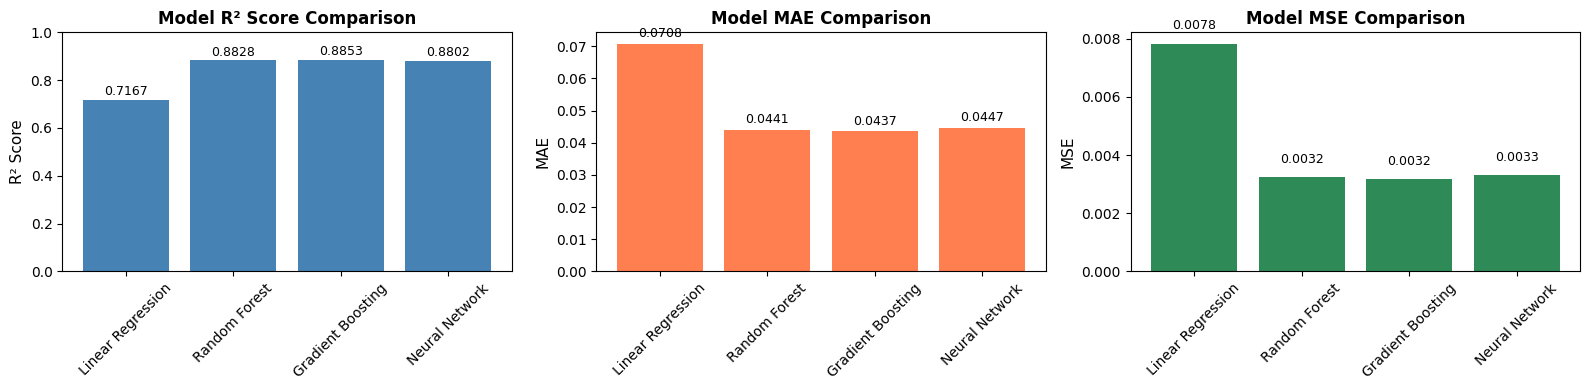

In [12]:
# Create a comparison DataFrame
results_df = pd.DataFrame(results)
print("\nMODEL PERFORMANCE COMPARISON (on Validation Set)")
print("="*70)
print(results_df.to_string(index=False))

# Find the best model by R² score
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
best_model = models[best_model_name]
best_r2 = results_df['R²'].max()

print(f"\n✓ Best model: {best_model_name} with R² = {best_r2:.4f}")

# Visualize model performance comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1: R² Scores
axes[0].bar(results_df['Model'], results_df['R²'], color='steelblue')
axes[0].set_ylabel('R² Score', fontsize=11)
axes[0].set_title('Model R² Score Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylim([0, 1])
for i, v in enumerate(results_df['R²']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=9)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: MAE (Mean Absolute Error)
axes[1].bar(results_df['Model'], results_df['MAE'], color='coral')
axes[1].set_ylabel('MAE', fontsize=11)
axes[1].set_title('Model MAE Comparison', fontsize=12, fontweight='bold')
for i, v in enumerate(results_df['MAE']):
    axes[1].text(i, v + 0.002, f'{v:.4f}', ha='center', fontsize=9)
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: MSE (Mean Squared Error)
axes[2].bar(results_df['Model'], results_df['MSE'], color='seagreen')
axes[2].set_ylabel('MSE', fontsize=11)
axes[2].set_title('Model MSE Comparison', fontsize=12, fontweight='bold')
for i, v in enumerate(results_df['MSE']):
    axes[2].text(i, v + 0.0005, f'{v:.4f}', ha='center', fontsize=9)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

As expected our non-linear models performs better than the linear regressor, as they are able to capture the non-linear relations in the data. 
They also reach very similar scores on the validation set, indicating that we've reached the upper limit of how well we can predict our target value. 
We can confirm this suspicion by looking at the leaderboard of the kaggle task.w 
All top performing teams achived similar scores on the test se

# Feature Importance Analysis

Understanding which features most influence accident risk predictions helps interpret the model and identify key risk factors.


TODO: expand this section, since it can count as extra credits

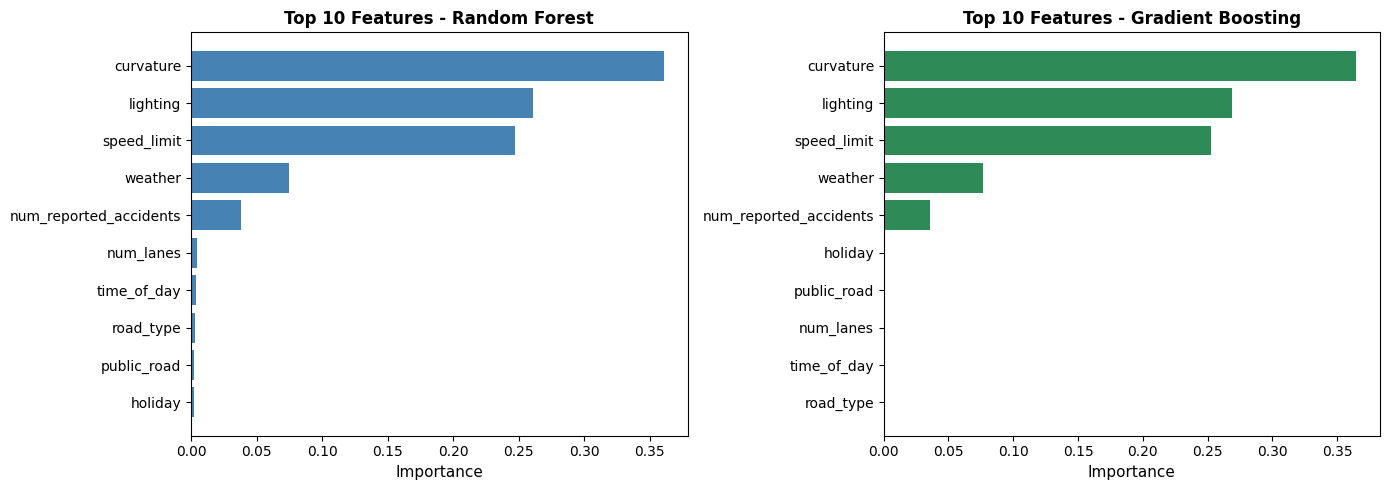


Top 10 Most Important Features (Random Forest):
               Feature  Importance
             curvature    0.360770
              lighting    0.261044
           speed_limit    0.246834
               weather    0.074525
num_reported_accidents    0.037827
             num_lanes    0.004345
           time_of_day    0.003286
             road_type    0.003256
           public_road    0.002114
               holiday    0.002056

Top 10 Most Important Features (Gradient Boosting):
               Feature  Importance
             curvature    0.364882
              lighting    0.269232
           speed_limit    0.252678
               weather    0.076870
num_reported_accidents    0.035398
               holiday    0.000286
           public_road    0.000242
             num_lanes    0.000140
           time_of_day    0.000086
             road_type    0.000074


In [13]:
# Extract feature importances from ensemble models
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance_gb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest Feature Importance
axes[0].barh(feature_importance_rf['Feature'][:10], feature_importance_rf['Importance'][:10], color='steelblue')
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].set_title('Top 10 Features - Random Forest', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# Gradient Boosting Feature Importance
axes[1].barh(feature_importance_gb['Feature'][:10], feature_importance_gb['Importance'][:10], color='seagreen')
axes[1].set_xlabel('Importance', fontsize=11)
axes[1].set_title('Top 10 Features - Gradient Boosting', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features (Random Forest):")
print(feature_importance_rf.head(10).to_string(index=False))

print("\nTop 10 Most Important Features (Gradient Boosting):")
print(feature_importance_gb.head(10).to_string(index=False))

### 4b. Advanced Feature Analysis: SHAP Values

SHAP (SHapley Additive exPlanations) values provide deeper insights into how features interact and collectively impact predictions. Unlike simple feature importance scores, SHAP values show:
- How each feature value contributes to individual predictions
- How features interact with each other
- The direction and magnitude of each feature's impact

In [85]:
# Reload util module to ensure SHAP functions are available
import importlib
importlib.reload(util)

<module 'util' from '/home/brage/uni/ai-industry/ai-industry-project/src/util.py'>

In [86]:
import shap

print("="*70)
print("ADVANCED FEATURE ANALYSIS: SHAP VALUES (OPTIMIZED)")
print("="*70)

# Calculate SHAP values for Random Forest ONLY (faster than Gradient Boosting)
print("\nCalculating SHAP values for Random Forest...")
print("(Note: Using only first 100 samples for faster computation)")
explainer_rf, shap_values_rf = util.calculate_shap_values(rf_model, X_val[:100], 'tree')

print("✓ SHAP values calculated successfully")


ADVANCED FEATURE ANALYSIS: SHAP VALUES (OPTIMIZED)

Calculating SHAP values for Random Forest...
(Note: Using only first 100 samples for faster computation)
✓ SHAP values calculated successfully


In [ ]:
import random

shap.initjs()

for i in random.sample(range(len(shap_values_rf)), 5):
    display(shap.plots.force(
        explainer_rf.expected_value,
        shap_values_rf[i],
        X_val.iloc[i],
        feature_names=X_val.columns
    ))


Generating SHAP summary plot...


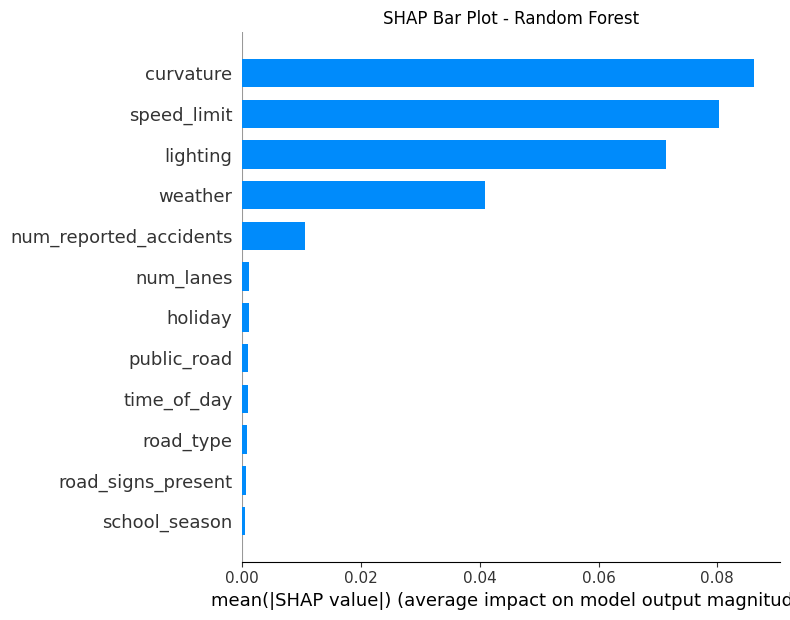


Generating dependence plot for top feature...
  Analyzing curvature...


<Figure size 640x480 with 0 Axes>

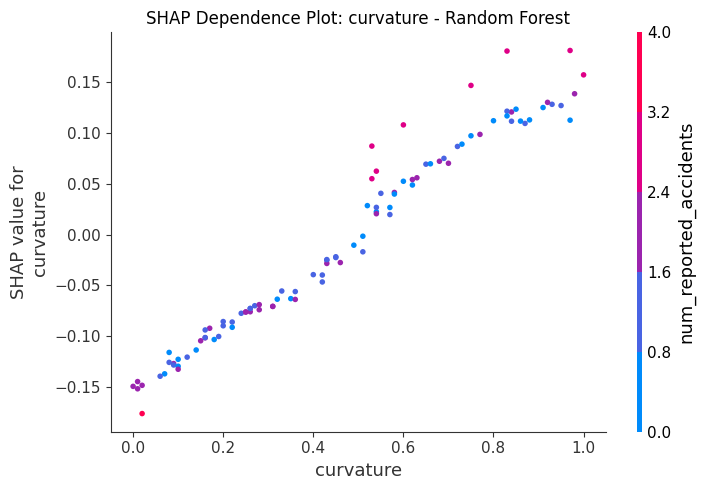


✓ SHAP analysis complete!

Optimized Analysis Notes:
  • Using first 100 validation samples (faster than all 400)
  • Random Forest only (faster than Gradient Boosting)
  • Bar plot: Aggregate feature importance
  • Dependence plot: Shows top feature interaction

For full analysis with all data/models, increase sample size or
comment out the [:100] slice in the code above.


In [88]:

# Summary plot - shows impact of each feature on predictions
print("\nGenerating SHAP summary plot...")
util.plot_shap_summary(shap_values_rf, X_val[:100], "Random Forest", plot_type="bar")

# Dependence plot for top feature ONLY (much faster than multiple)
print("\nGenerating dependence plot for top feature...")
top_feature = feature_importance_rf['Feature'].iloc[0]
print(f"  Analyzing {top_feature}...")
util.plot_shap_dependence(shap_values_rf, X_val[:100], top_feature, "Random Forest")

print("\n✓ SHAP analysis complete!")
print("\nOptimized Analysis Notes:")
print("  • Using first 100 validation samples (faster than all 400)")
print("  • Random Forest only (faster than Gradient Boosting)")
print("  • Bar plot: Aggregate feature importance")
print("  • Dependence plot: Shows top feature interaction")
print("\nFor full analysis with all data/models, increase sample size or")
print("comment out the [:100] slice in the code above.")